In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

import parmed as pmd
import openmm
import openmm.app as app
import openmm.unit as u
import numpy as np

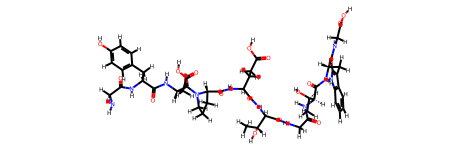

In [10]:
chignolin = Chem.rdmolfiles.MolFromFASTA("GYDPETGTWG")
chignolin = Chem.AddHs(chignolin)
AllChem.MMFFSanitizeMolecule(chignolin)
Chem.rdDistGeom.EmbedMolecule(chignolin)

chignolin

In [11]:
def compare_energies(mol, toppar_filenames, system_kwargs=None, units=u.kilojoules_per_mole):
    psf_filename = "mol.psf"
    pmd_chignolin = pmd.load_rdkit(chignolin)
    pmd_chignolin.write_psf(psf_filename)
    
    openmm_toppar = app.CharmmParameterSet(*toppar_filenames)
    openmm_psf = app.CharmmPsfFile(psf_filename)
    openmm_system = openmm_psf.createSystem(openmm_toppar, **system_kwargs)

    integrator = openmm.VerletIntegrator(1.0)
    platform = openmm.Platform.getPlatformByName("CPU")
    simulation = app.Simulation(openmm_psf.topology, openmm_system, integrator, platform)
    
    conf = mol.GetConformer(0)
    positions = conf.GetPositions()
    simulation.context.setPositions(positions)

    print(simulation.context.getState(getEnergy=True).getPotentialEnergy())
    # simulation.minimizeEnergy(maxIterations=500)
    # print(simulation.context.getState(getEnergy=True).getPotentialEnergy())

In [12]:
SOLVENT_KWARGS = {
    "nonbondedMethod": app.NoCutoff,
    "constraints": app.HBonds,
    "implicitSolvent": app.HCT,
    "rigidWater": True,
}
    
compare_energies(
    chignolin,
    ["toppar/par_all36_prot.prm", "toppar/top_all36_prot.rtf","toppar/toppar_water_ions.str"], 
    system_kwargs=SOLVENT_KWARGS
)

MissingParameter: Could not find atom type for CB

In [13]:
pmd_chignolin = pmd.load_rdkit(chignolin)
pmd_chignolin.visualize()

NGLWidget()